## Spark Setup

In [1]:
# Mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# START INIT ENVIRONMENT
!ls /content/drive/MyDrive/Project_2024/DES_Project/Spark/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq >/dev/null
!tar xf /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"

/content/drive/MyDrive/Project_2024/DES_Project/Spark/spark-3.5.2-bin-hadoop3.tgz


In [3]:
# START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Flight Delay Prediction")\
         .getOrCreate()

In [4]:
# BASE IMPORTS

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import time
from pyspark.sql.functions import count as spark_count
from pyspark.sql import functions as F

In [5]:
!pip install pyspark
!pip install pandas
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00


In [6]:
# Load the dataset
flights = spark.read.csv("/content/drive/My Drive/Project_2024/DES_Project/Flight_Dataset_July24.csv", header=True, inferSchema=True)

In [7]:
# Selecting relevant columns

flights2 = flights.select(
    "DayofMonth", "DayOfWeek", "Operating_Airline ", "OriginCityName", "DestCityName",
    "CRSDepTime", "DepTime", "DepDelay", "DepDelayMinutes", "WheelsOff", "WheelsOn",
    "CRSArrTime", "ArrTime", "ArrDelay", "ArrDelayMinutes", "Cancelled", "Diverted",
    "ActualElapsedTime", "Distance", "CarrierDelay", "WeatherDelay", "NASDelay",
    "SecurityDelay", "LateAircraftDelay"
)

flights2.show(5)

+----------+---------+------------------+--------------------+-------------------+----------+-------+--------+---------------+---------+--------+----------+-------+--------+---------------+---------+--------+-----------------+--------+------------+------------+--------+-------------+-----------------+
|DayofMonth|DayOfWeek|Operating_Airline |      OriginCityName|       DestCityName|CRSDepTime|DepTime|DepDelay|DepDelayMinutes|WheelsOff|WheelsOn|CRSArrTime|ArrTime|ArrDelay|ArrDelayMinutes|Cancelled|Diverted|ActualElapsedTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----------+---------+------------------+--------------------+-------------------+----------+-------+--------+---------------+---------+--------+----------+-------+--------+---------------+---------+--------+-----------------+--------+------------+------------+--------+-------------+-----------------+
|        29|        1|                NK|Dallas/Fort Worth...|Fort Lauderdale, FL|      102

In [8]:
# Handling Null Values

# List of columns to check for null values
columns_to_check = [
    "DepTime", "DepDelay", "DepDelayMinutes", "WheelsOff", "WheelsOn",
    "ArrTime", "ArrDelay", "ArrDelayMinutes", "ActualElapsedTime"
]

# Drop rows with null values in the specified columns
flights_cleaned = flights2.dropna(subset=columns_to_check)

#Columns to impute with 0
columns_to_impute = [
    "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"
]

# missing values to 0
flights_cleaned = flights_cleaned.fillna(0, subset=columns_to_impute)


# percentage of null values
null_percentages = flights_cleaned.select([
    ((count(when(col(c).isNull() | isnan(c), c)) / count(lit(1))) * 100).alias(c) for c in flights_cleaned.columns
])

null_percentages.show()

+----------+---------+------------------+--------------+------------+----------+-------+--------+---------------+---------+--------+----------+-------+--------+---------------+---------+--------+-----------------+--------+------------+------------+--------+-------------+-----------------+
|DayofMonth|DayOfWeek|Operating_Airline |OriginCityName|DestCityName|CRSDepTime|DepTime|DepDelay|DepDelayMinutes|WheelsOff|WheelsOn|CRSArrTime|ArrTime|ArrDelay|ArrDelayMinutes|Cancelled|Diverted|ActualElapsedTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----------+---------+------------------+--------------+------------+----------+-------+--------+---------------+---------+--------+----------+-------+--------+---------------+---------+--------+-----------------+--------+------------+------------+--------+-------------+-----------------+
|       0.0|      0.0|               0.0|           0.0|         0.0|       0.0|    0.0|     0.0|            0.0|      0.0|     0.

In [9]:
# Mapping Airlines against Airline Codes

airline_dict = {
    "UA": "United Airlines",
    "NK": "Spirit Airlines",
    "AA": "American Airlines",
    "OO": "SkyWest Airlines",
    "YV": "Mesa Airlines",
    "C5": "CommutAir",
    "OH": "PSA Airlines",
    "G7": "GoJet Airlines",
    "9E": "Endeavor Air",
    "B6": "JetBlue Airways",
    "PT": "Piedmont Airlines",
    "DL": "Delta Air Lines",
    "F9": "Frontier Airlines",
    "MQ": "Envoy Air",
    "HA": "Hawaiian Airlines",
    "G4": "Allegiant Air",
    "ZW": "Air Wisconsin",
    "YX": "Republic Airways",
    "AS": "Alaska Airlines",
    "QX": "Horizon Air",
    "WN": "Southwest Airlines",
    "EV": "ExpressJet Airlines",
    "VX": "Virgin America"
}

airline_df = spark.createDataFrame(airline_dict.items(), ["Operating_Airline ", "Operating_Airline_Name"])
broadcast_airline_df = broadcast(airline_df)

# Join the original DataFrame and broadcasted DataFrame
flights_mapped = flights_cleaned.join(broadcast_airline_df, flights_cleaned['Operating_Airline '] == broadcast_airline_df['Operating_Airline '], 'left').drop(broadcast_airline_df['Operating_Airline '])

flights_mapped = flights_mapped.drop("Operating_Airline ")

# Join the original DataFrame and broadcasted DataFrame
flights3 = flights2.join(broadcast_airline_df, flights_cleaned['Operating_Airline '] == broadcast_airline_df['Operating_Airline '], 'left').drop(broadcast_airline_df['Operating_Airline '])

flights_mapped = flights_mapped.drop("Operating_Airline ")


In [10]:
# Time related conversions

# Extracting City Names
flights3 = flights_mapped.withColumn("OriginCityName", substring_index(col("OriginCityName"), ",", 1))
flights_set = flights3.withColumn("DestCityName", substring_index(col("DestCityName"), ",", 1))

# Handle invalid time values and convert to timestamp format
time_columns = ["CRSDepTime", "DepTime", "WheelsOff", "WheelsOn", "CRSArrTime", "ArrTime"]
for col_name in time_columns:
    flights_set = flights_set.withColumn(col_name,
                                         when(col(col_name).isNotNull() & (col(col_name) < 2400),
                                              to_timestamp(format_string("%04d", col(col_name)), "HHmm"))
                                         .otherwise(None))

# Extract the hour and minute
for col_name in time_columns:
    hour_col = col_name + "Hour"
    minute_col = col_name + "Minute"
    flights_set = flights_set.withColumn(hour_col, hour(col(col_name))) \
                             .withColumn(minute_col, minute(col(col_name)))

flights_set = flights_set.fillna(0)
flights_set = flights_set.drop("CRSDepTime", "DepTime", "WheelsOff", "WheelsOn", "CRSArrTime", "ArrTime")

In [11]:
# Bucketing features

# Bucketing Delays
flights_set = flights_set.withColumn(
    "Delay",
    when(
        ((col("DepDelayMinutes").isNotNull()) & (col("DepDelayMinutes") > 0)),
        1
    ).otherwise(0)
)

# new column 'FlightStatus' classifying flights
flights_set = flights_set.withColumn(
    "FlightStatus",
    when(col("Cancelled") == 1, "Cancelled")
    .when(col("Diverted") == 1, "Diverted")
    .when(col("Delay") == 1, "Delayed")
    .otherwise("On Time")
)

flights_set = flights_set.withColumn("Weekday", when(col("DayOfWeek").isin([1, 2, 3, 4, 5]), 1).otherwise(0))
flights_set = flights_set.withColumn("Weekend", when(col("DayOfWeek").isin([6,7]), 1).otherwise(0))

In [12]:
# Cast relevant columns to DoubleType for numerical analysis

# Convert relevant columns to double type
columns_to_convert = ['DepDelay', 'DepDelayMinutes', 'ArrDelay', 'ArrDelayMinutes', 'Cancelled', 'Diverted', 'ActualElapsedTime', 'Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

for column in columns_to_convert:
    flights_pred = flights_set.withColumn(column, col(column).cast('double'))

flights_pred.printSchema()

root
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepDelay: double (nullable = false)
 |-- DepDelayMinutes: double (nullable = false)
 |-- ArrDelay: double (nullable = false)
 |-- ArrDelayMinutes: double (nullable = false)
 |-- Cancelled: double (nullable = false)
 |-- Diverted: double (nullable = false)
 |-- ActualElapsedTime: double (nullable = false)
 |-- Distance: double (nullable = false)
 |-- CarrierDelay: double (nullable = false)
 |-- WeatherDelay: double (nullable = false)
 |-- NASDelay: double (nullable = false)
 |-- SecurityDelay: double (nullable = false)
 |-- LateAircraftDelay: double (nullable = false)
 |-- Operating_Airline_Name: string (nullable = true)
 |-- CRSDepTimeHour: integer (nullable = true)
 |-- CRSDepTimeMinute: integer (nullable = true)
 |-- DepTimeHour: integer (nullable = true)
 |-- DepTimeMinute: integer (nullable = true)
 

In [13]:
# Bucketing Delay Types

delay_pred = flights_pred.withColumn("MaxDelayReason", greatest("CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"))

delay_pred = delay_pred.withColumn("Reason",
    when(col("MaxDelayReason") == col("CarrierDelay"), "CarrierDelay")
    .when(col("MaxDelayReason") == col("WeatherDelay"), "WeatherDelay")
    .when(col("MaxDelayReason") == col("NASDelay"), "NASDelay")
    .when(col("MaxDelayReason") == col("SecurityDelay"), "SecurityDelay")
    .when(col("MaxDelayReason") == col("LateAircraftDelay"), "LateAircraftDelay")
    .otherwise(lit(None))
)

In [14]:
# Linear Regression

feature_cols1 = ['SecurityDelay', 'WeatherDelay', 'LateAircraftDelay', 'CRSDepTimeHour', 'CRSArrTimeHour',
                   'CarrierDelay', 'NASDelay', 'DepTimeHour', 'WheelsOffHour', 'WheelsOnHour', 'DayofMonth', 'Weekend']

assembler1 = VectorAssembler(inputCols=feature_cols1, outputCol="features1")

scaler = StandardScaler(inputCol="features1", outputCol="scaledFeatures")

dep_delay_lr1 = LinearRegression(labelCol="DepDelay", featuresCol="scaledFeatures")
arr_delay_lr1 = LinearRegression(labelCol="ArrDelay", featuresCol="scaledFeatures")

dep_delay_pipeline1 = Pipeline(stages=[assembler1, scaler, dep_delay_lr1])
arr_delay_pipeline1 = Pipeline(stages=[assembler1, scaler, arr_delay_lr1])

train_data1, test_data1 = delay_pred.randomSplit([0.8, 0.2], seed=1234)

dep_delay_model1 = dep_delay_pipeline1.fit(train_data1)
arr_delay_model1 = arr_delay_pipeline1.fit(train_data1)

# predictions-test set
dep_delay_predictions1 = dep_delay_model1.transform(test_data1)
arr_delay_predictions1 = arr_delay_model1.transform(test_data1)

#predictions- training set
train_dep_delay_predictions1 = dep_delay_model1.transform(train_data1)
train_arr_delay_predictions1 = arr_delay_model1.transform(train_data1)


In [15]:
# Evaluate the LR model

r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="DepDelay", metricName="r2")
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="DepDelay", metricName="rmse")
mae_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="DepDelay", metricName="mae")

# DepDelay model - test data
test_r2_dep = r2_evaluator.evaluate(dep_delay_predictions1)
test_rmse_dep = rmse_evaluator.evaluate(dep_delay_predictions1)
test_mae_dep = mae_evaluator.evaluate(dep_delay_predictions1)

print(f"DepDelay Model - Test Data: R2 = {test_r2_dep}, RMSE = {test_rmse_dep}, MAE = {test_mae_dep}")

r2_evaluator.setLabelCol("ArrDelay")
rmse_evaluator.setLabelCol("ArrDelay")
mae_evaluator.setLabelCol("ArrDelay")

test_r2_arr = r2_evaluator.evaluate(arr_delay_predictions1)
test_rmse_arr = rmse_evaluator.evaluate(arr_delay_predictions1)
test_mae_arr = mae_evaluator.evaluate(arr_delay_predictions1)

print(f"ArrDelay Model - Test Data: R2 = {test_r2_arr}, RMSE = {test_rmse_arr}, MAE = {test_mae_arr}")

DepDelay Model - Test Data: R2 = 0.9694343900534843, RMSE = 12.01652353389442, MAE = 7.81373619054523
ArrDelay Model - Test Data: R2 = 0.9815373538864137, RMSE = 9.59432459749448, MAE = 7.475614015526361


In [16]:
#LInear Regression with D columns
# Add categorical columns to the predictions dataframes
dep_delay_predictions2 = dep_delay_predictions1.withColumn("OriginCityName", train_data1["OriginCityName"])
dep_delay_predictions2 = dep_delay_predictions2.withColumn("DestCityName", train_data1["DestCityName"])
dep_delay_predictions2 = dep_delay_predictions2.withColumn("Operating_Airline_Name", train_data1["Operating_Airline_Name"])

arr_delay_predictions2 = arr_delay_predictions1.withColumn("OriginCityName", train_data1["OriginCityName"])
arr_delay_predictions2 = arr_delay_predictions2.withColumn("DestCityName", train_data1["DestCityName"])
arr_delay_predictions2 = arr_delay_predictions2.withColumn("Operating_Airline_Name", train_data1["Operating_Airline_Name"])

In [17]:
from pyspark.sql.functions import col, min, max


dep_actual_min = dep_delay_predictions1.agg(min(col("DepDelay"))).collect()[0][0]
dep_actual_max = dep_delay_predictions1.agg(max(col("DepDelay"))).collect()[0][0]

dep_pred_min = dep_delay_predictions1.agg(min(col("prediction"))).collect()[0][0]
dep_pred_max = dep_delay_predictions1.agg(max(col("prediction"))).collect()[0][0]

arr_actual_min = arr_delay_predictions1.agg(min(col("ArrDelay"))).collect()[0][0]
arr_actual_max = arr_delay_predictions1.agg(max(col("ArrDelay"))).collect()[0][0]

arr_pred_min = arr_delay_predictions1.agg(min(col("prediction"))).collect()[0][0]
arr_pred_max = arr_delay_predictions1.agg(max(col("prediction"))).collect()[0][0]

dep_range_coverage = (dep_pred_min <= dep_actual_min) and (dep_pred_max >= dep_actual_max)
arr_range_coverage = (arr_pred_min <= arr_actual_min) and (arr_pred_max >= arr_actual_max)

print(f"Departure Delay Actual Range: {dep_actual_min} to {dep_actual_max}")
print(f"Departure Delay Prediction Range: {dep_pred_min} to {dep_pred_max}")

print(f"Arrival Delay Actual Range: {arr_actual_min} to {arr_actual_max}")
print(f"Arrival Delay Prediction Range: {arr_pred_min} to {arr_pred_max}")


Departure Delay Actual Range: -38.0 to 1878.0
Departure Delay Prediction Range: -4.6309517559028315 to 1921.2015965158616
Arrival Delay Actual Range: -59.0 to 1892.0
Arrival Delay Prediction Range: -11.80809054535202 to 1924.2234290849349


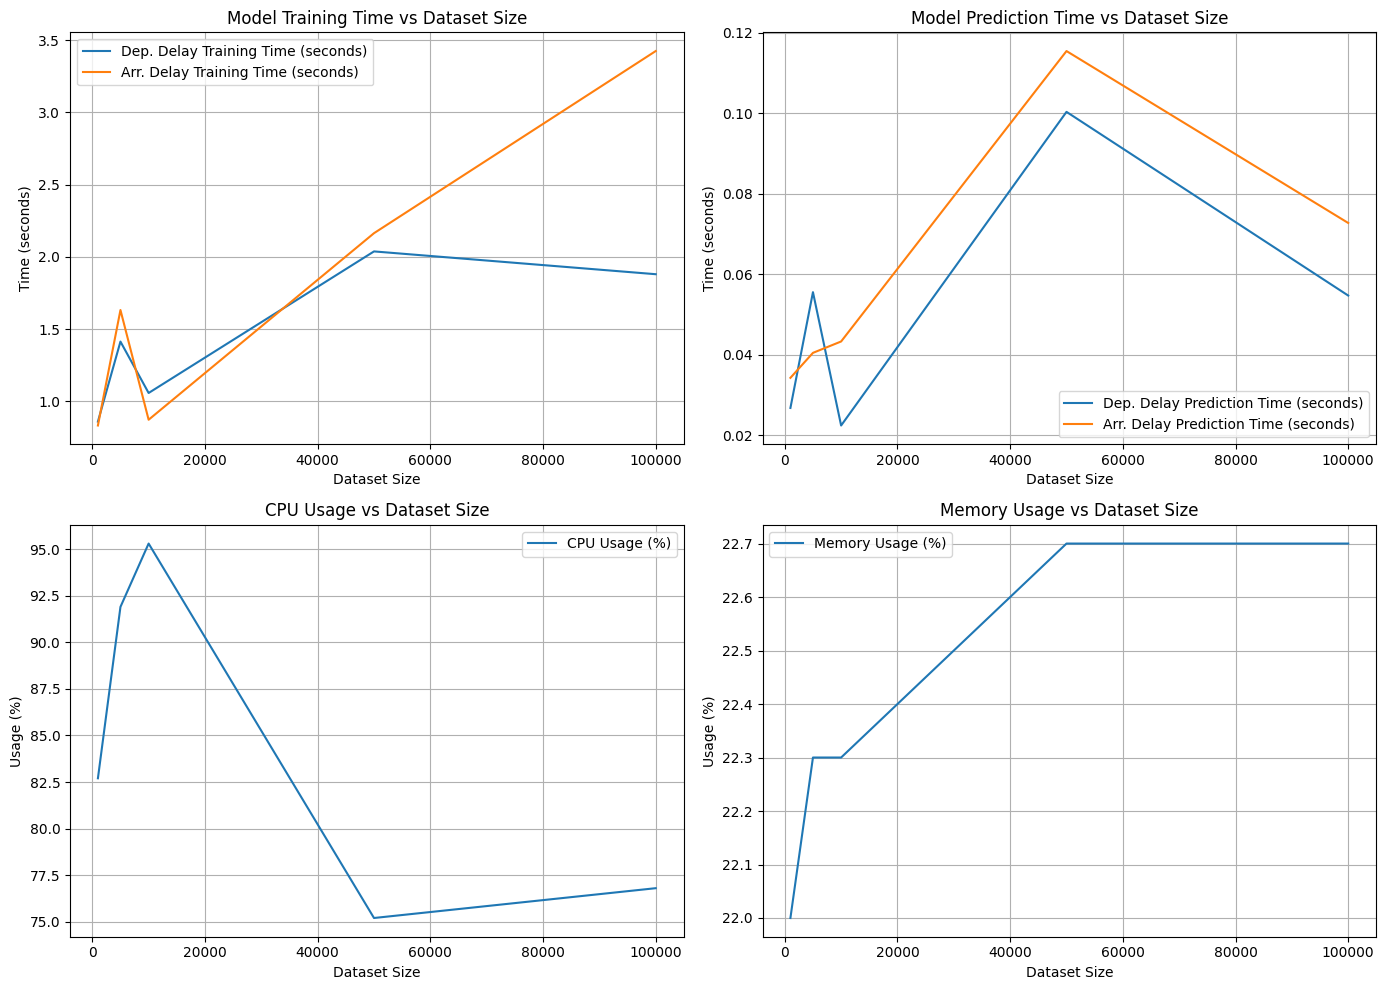

In [18]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
import psutil


spark = SparkSession.builder.appName("ScalabilityTest").getOrCreate()

def generate_dataset(num_samples):
    np.random.seed(1234)
    data = {
        'SecurityDelay': np.random.randint(0, 60, num_samples),
        'WeatherDelay': np.random.randint(0, 60, num_samples),
        'LateAircraftDelay': np.random.randint(0, 60, num_samples),
        'CRSDepTimeHour': np.random.randint(0, 24, num_samples),
        'CRSArrTimeHour': np.random.randint(0, 24, num_samples),
        'CarrierDelay': np.random.randint(0, 60, num_samples),
        'NASDelay': np.random.randint(0, 60, num_samples),
        'DepTimeHour': np.random.randint(0, 24, num_samples),
        'WheelsOffHour': np.random.randint(0, 24, num_samples),
        'WheelsOnHour': np.random.randint(0, 24, num_samples),
        'DayofMonth': np.random.randint(1, 32, num_samples),
        'Weekend': np.random.randint(0, 2, num_samples),
        'DepDelay': np.random.randint(-30, 180, num_samples),
        'ArrDelay': np.random.randint(-30, 180, num_samples),
    }
    return pd.DataFrame(data)


dataset_sizes = [1000, 5000, 10000, 50000, 100000]

dep_training_times = []
dep_prediction_times = []
arr_training_times = []
arr_prediction_times = []
cpu_usages = []
memory_usages = []

for size in dataset_sizes:
    dataset = generate_dataset(size)
    dataset_spark = spark.createDataFrame(dataset)

    feature_cols = ['SecurityDelay', 'WeatherDelay', 'LateAircraftDelay', 'CRSDepTimeHour', 'CRSArrTimeHour',
                    'CarrierDelay', 'NASDelay', 'DepTimeHour', 'WheelsOffHour', 'WheelsOnHour', 'DayofMonth', 'Weekend']
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
    assembled_data = assembler.transform(dataset_spark)
    scaled_data = scaler.fit(assembled_data).transform(assembled_data)

    dep_lr = LinearRegression(labelCol="DepDelay", featuresCol="scaledFeatures")
    arr_lr = LinearRegression(labelCol="ArrDelay", featuresCol="scaledFeatures")

    start_time = time.time()
    dep_model = dep_lr.fit(scaled_data)
    dep_training_times.append(time.time() - start_time)
    start_time = time.time()
    dep_predictions = dep_model.transform(scaled_data)
    dep_prediction_times.append(time.time() - start_time)
    start_time = time.time()
    arr_model = arr_lr.fit(scaled_data)
    arr_training_times.append(time.time() - start_time)
    start_time = time.time()
    arr_predictions = arr_model.transform(scaled_data)
    arr_prediction_times.append(time.time() - start_time)
    cpu_usages.append(psutil.cpu_percent(interval=None))
    memory_usages.append(psutil.virtual_memory().percent)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(dataset_sizes, dep_training_times, label='Dep. Delay Training Time (seconds)')
plt.plot(dataset_sizes, arr_training_times, label='Arr. Delay Training Time (seconds)')
plt.xlabel('Dataset Size')
plt.ylabel('Time (seconds)')
plt.title('Model Training Time vs Dataset Size')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
plt.plot(dataset_sizes, dep_prediction_times, label='Dep. Delay Prediction Time (seconds)')
plt.plot(dataset_sizes, arr_prediction_times, label='Arr. Delay Prediction Time (seconds)')
plt.xlabel('Dataset Size')
plt.ylabel('Time (seconds)')
plt.title('Model Prediction Time vs Dataset Size')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(dataset_sizes, cpu_usages, label='CPU Usage (%)')
plt.xlabel('Dataset Size')
plt.ylabel('Usage (%)')
plt.title('CPU Usage vs Dataset Size')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(dataset_sizes, memory_usages, label='Memory Usage (%)')
plt.xlabel('Dataset Size')
plt.ylabel('Usage (%)')
plt.title('Memory Usage vs Dataset Size')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
from datetime import datetime
import builtins

def predict_delays(origin, destination, airline, dep_time_hour, month, day):
    try:
        date = datetime(2024, month, day)
    except ValueError:
        return "Invalid date. Please enter a valid day for the given month."

    weekend = 1 if date.weekday() >= 5 else 0

    input_data = pd.DataFrame({
        'OriginCityName': [origin],
        'DestCityName': [destination],
        'Operating_Airline_Name': [airline],
        'SecurityDelay': [0],
        'WeatherDelay': [0],
        'LateAircraftDelay': [0],
        'CRSDepTimeHour': [dep_time_hour],
        'CRSArrTimeHour': [0],
        'CarrierDelay': [0],
        'NASDelay': [0],
        'DepTimeHour': [dep_time_hour],
        'WheelsOffHour': [0],
        'WheelsOnHour': [0],
        'DayofMonth': [day],
        'Weekend': [weekend]
    })

    input_spark_df = spark.createDataFrame(input_data)
    dep_delay_prediction = dep_delay_model1.transform(input_spark_df).select("prediction").collect()[0][0]
    dep_delay_prediction = builtins.max(0, dep_delay_prediction)
    return dep_delay_prediction

In [31]:
import ipywidgets as widgets
from IPython.display import display

origin_widget = widgets.Text(description="Origin:")
destination_widget = widgets.Text(description="Destination:")
airline_widget = widgets.Text(description="Airline:")
dep_time_hour_widget = widgets.IntSlider(min=0, max=23, description="Dep Hour:")
month_widget = widgets.IntSlider(min=1, max=12, description="Month:")
day_widget = widgets.IntSlider(min=1, max=31, description="Day:")


output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        origin = origin_widget.value
        destination = destination_widget.value
        airline = airline_widget.value
        dep_time_hour = dep_time_hour_widget.value
        month = month_widget.value
        day = day_widget.value

        result = predict_delays(origin, destination, airline, dep_time_hour, month, day)
        if isinstance(result, str):
            print(result)
        else:
            dep_delay = result
            print(f"Predicted Departure Delay: {dep_delay:.2f} minutes")
button = widgets.Button(description="Predict Delays")
button.on_click(on_button_click)

display(origin_widget, destination_widget, airline_widget, dep_time_hour_widget, month_widget, day_widget, button, output)


#Aberdeen| Minneapolis SkyWest Airlines
#Albuquerque|   Chicago    American Airlines
#Aberdeen|      Minneapolis|     SkyWest Airlines|
# Albuquerque|   Chicago    American Airlines
# Alpena|          Detroit
# Alexandria|Atlanta |Endeavor Air
# Amarillo|Denver|SkyWest Airlines|
# Anchorage|Dallas/Fort Worth|American Airlines|


# dep_delay_predictions2

Text(value='', description='Origin:')

Text(value='', description='Destination:')

Text(value='', description='Airline:')

IntSlider(value=0, description='Dep Hour:', max=23)

IntSlider(value=1, description='Month:', max=12, min=1)

IntSlider(value=1, description='Day:', max=31, min=1)

Button(description='Predict Delays', style=ButtonStyle())

Output()

In [30]:
dep_delay_predictions2.show(15)
 #Aberdeen|      Minneapolis|     SkyWest Airlines|
# Albuquerque|   Chicago    American Airlines
# Alpena|          Detroit
# Alexandria|Atlanta |Endeavor Air
# Amarillo|Denver|SkyWest Airlines|
# Anchorage|Dallas/Fort Worth|American Airlines|

+----------+---------+--------------------+-----------------+--------+---------------+--------+---------------+---------+--------+-----------------+--------+------------+------------+--------+-------------+-----------------+----------------------+--------------+----------------+-----------+-------------+-------------+---------------+------------+--------------+--------------+----------------+-----------+-------------+-----+------------+-------+-------+--------------+------------+--------------------+--------------------+-------------------+
|DayofMonth|DayOfWeek|      OriginCityName|     DestCityName|DepDelay|DepDelayMinutes|ArrDelay|ArrDelayMinutes|Cancelled|Diverted|ActualElapsedTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|Operating_Airline_Name|CRSDepTimeHour|CRSDepTimeMinute|DepTimeHour|DepTimeMinute|WheelsOffHour|WheelsOffMinute|WheelsOnHour|WheelsOnMinute|CRSArrTimeHour|CRSArrTimeMinute|ArrTimeHour|ArrTimeMinute|Delay|FlightStatus|Weekday|Weeke

#### Random Forest

In [21]:
# Random Forest

rf_feature_cols = ['CRSArrTimeHour', 'CRSArrTimeMinute', 'CRSDepTimeHour', 'CRSDepTimeMinute','DepTimeHour', 'DayOfWeek', 'Weekday',  'DayofMonth', 'WheelsOffMinute', 'WheelsOnMinute']

rf_assembler = VectorAssembler(inputCols=rf_feature_cols, outputCol="rf_features")

rf_scaler = StandardScaler(inputCol="rf_features", outputCol="rf_scaledFeatures")

dep_delay_rf = RandomForestRegressor(labelCol="DepDelay", featuresCol="rf_scaledFeatures", numTrees=50, maxDepth=10)
arr_delay_rf = RandomForestRegressor(labelCol="ArrDelay", featuresCol="rf_scaledFeatures", numTrees=50, maxDepth=10)

rf_dep_delay_pipeline = Pipeline(stages=[rf_assembler, rf_scaler, dep_delay_rf])
rf_arr_delay_pipeline = Pipeline(stages=[rf_assembler, rf_scaler, arr_delay_rf])

rf_train_data, rf_test_data = delay_pred.randomSplit([0.8, 0.2], seed=1234)

rf_dep_delay_model = rf_dep_delay_pipeline.fit(rf_train_data)
rf_arr_delay_model = rf_arr_delay_pipeline.fit(rf_train_data)

# predictions - test set
rf_dep_delay_predictions_test = rf_dep_delay_model.transform(rf_test_data)
rf_arr_delay_predictions_test = rf_arr_delay_model.transform(rf_test_data)

# predictions - training set
rf_dep_delay_predictions_train = rf_dep_delay_model.transform(rf_train_data)
rf_arr_delay_predictions_train = rf_arr_delay_model.transform(rf_train_data)


In [22]:
# Evaluate the RF model

def evaluate_model(predictions, label_col):
    evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    return rmse, mae, r2

dep_delay_rmse_test, dep_delay_mae_test, dep_delay_r2_test = evaluate_model(rf_dep_delay_predictions_test, "DepDelay")
print(f"DepDelay Test - RMSE: {dep_delay_rmse_test}, MAE: {dep_delay_mae_test}, R2: {dep_delay_r2_test}")


arr_delay_rmse_test, arr_delay_mae_test, arr_delay_r2_test = evaluate_model(rf_arr_delay_predictions_test, "ArrDelay")
print(f"ArrDelay Test - RMSE: {arr_delay_rmse_test}, MAE: {arr_delay_mae_test}, R2: {arr_delay_r2_test}")

DepDelay Test - RMSE: 30.662994579117676, MAE: 16.83582284812054, R2: 0.8009764280254543
ArrDelay Test - RMSE: 33.35638656658427, MAE: 19.85549190271061, R2: 0.7768365191930684


In [23]:
#Random Forest
# Add categorical columns to the predictions dataframes
rf_dep_delay_predictions_test1 = rf_dep_delay_predictions_test.withColumn("OriginCityName", rf_test_data["OriginCityName"])
rf_dep_delay_predictions_test1 = rf_dep_delay_predictions_test1.withColumn("DestCityName", rf_test_data["DestCityName"])
rf_dep_delay_predictions_test1 = rf_dep_delay_predictions_test1.withColumn("Operating_Airline_Name", rf_test_data["Operating_Airline_Name"])

rf_arr_delay_predictions_test1 = rf_arr_delay_predictions_test.withColumn("OriginCityName", rf_test_data["OriginCityName"])
rf_arr_delay_predictions_test1 = rf_arr_delay_predictions_test1.withColumn("DestCityName", rf_test_data["DestCityName"])
rf_arr_delay_predictions_test1 = rf_arr_delay_predictions_test1.withColumn("Operating_Airline_Name", rf_test_data["Operating_Airline_Name"])


In [24]:
import pandas as pd
from datetime import datetime
import builtins

def predict_delays(origin, destination, airline, dep_time_hour, month, day):
    try:
        date = datetime(2024, month, day)
    except ValueError:
        return "Invalid date. Please enter a valid day for the given month."
    input_data = pd.DataFrame({
        'OriginCityName': [origin],
        'DestCityName': [destination],
        'Operating_Airline_Name': [airline],
        'CRSDepTimeHour': [dep_time_hour],
        'CRSArrTimeHour': [0],
        'CRSArrTimeMinute': [0],
        'CRSDepTimeMinute': [0],
        'DepTimeHour': [0],
        'WheelsOffMinute': [0],
        'WheelsOnMinute': [0],
        'DayofMonth': [day],
        'Month': [month],
        'DayOfWeek': [date.weekday()],
        'Weekday': [1 if date.weekday() < 5 else 0],
        'DepTimeHour': [dep_time_hour]
    })

    input_spark_df = spark.createDataFrame(input_data)

    dep_delay_prediction = rf_dep_delay_model.transform(input_spark_df).select("prediction").collect()[0][0]
    dep_delay_prediction = builtins.max(0, dep_delay_prediction)
    return dep_delay_prediction

In [25]:
import ipywidgets as widgets
from IPython.display import display

origin_widget = widgets.Text(description="Origin:")
destination_widget = widgets.Text(description="Destination:")
airline_widget = widgets.Text(description="Airline:")
dep_time_hour_widget = widgets.IntSlider(min=0, max=23, description="Dep Hour:")
month_widget = widgets.IntSlider(min=1, max=12, description="Month:")
day_widget = widgets.IntSlider(min=1, max=31, description="Day:")

output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        origin = origin_widget.value
        destination = destination_widget.value
        airline = airline_widget.value
        dep_time_hour = dep_time_hour_widget.value
        month = month_widget.value
        day = day_widget.value

        result = predict_delays(origin, destination, airline, dep_time_hour, month, day)
        if isinstance(result, str):
            print(result)
        else:
            dep_delay = result
            print(f"Predicted Departure Delay: {dep_delay:.2f} minutes")

button = widgets.Button(description="Predict Delays")
button.on_click(on_button_click)

display(origin_widget, destination_widget, airline_widget, dep_time_hour_widget, month_widget, day_widget, button, output)

  #Akron|   Charlotte|          PSA Airlines
  #Albany|  Washington|         PSA Airlines
  #Aberdeen| Minneapolis

Text(value='', description='Origin:')

Text(value='', description='Destination:')

Text(value='', description='Airline:')

IntSlider(value=0, description='Dep Hour:', max=23)

IntSlider(value=1, description='Month:', max=12, min=1)

IntSlider(value=1, description='Day:', max=31, min=1)

Button(description='Predict Delays', style=ButtonStyle())

Output()